In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import os
from scipy.io import wavfile
#import torch
#import torch.nn as nn
#import torch.optim as optim
import pickle
from IPython.display import clear_output
from IPython.core.debugger import set_trace
from scipy.io import wavfile
#from torch.utils.data import DataLoader
from pathlib import Path
#from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
#from speechpy.feature import mfcc
from datetime import datetime
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()

from pandas.io.json import json_normalize

## Visualizations

In [125]:
coladam = "#3e9eab"
# color for adamW
coladamW = "#db2e59"
# color for SGD
colSGD = "#ffa200"

def augment_data(loss,N):
    """
    create additional fake data similar to loss with gaussian noise
    
    Args:
        loss(list of float): losses from one run
        N(int): number of simulated runs to create
    """
    return np.abs((np.random.normal(0,0.0003,[N,23]) + loss).T)

def get_inputs_linreg(losses):
    """
    return the x y necessary to fit a linear regression
    
    Args:
        losses (list of list of int): all nested lists don't necessarily have the same shape because of early stopping: list of the metric for a given
        combination of hyperparameters
        
    Returns:
        X,y (np.array): data fitted for the input of Linear Regression fitter
    """
    losses = np.asarray(losses)
    X = [np.arange(len(run))+1 for run in losses]
    X = np.concatenate(X,axis=None)
    X = np.expand_dims(X,axis = 1)
    #X = np.expand_dims(X.flatten(),axis = 1)
    y = np.concatenate(losses,axis=None)
    return X,y

def plot_losses_fits(losses, 
                     ax, 
                     colors,
                     plot_runs=True,
                     plot_fit=False,
                     plot_mean=False,
                     fit_type="log",
                     label=""):
    """
    Plot the fitted both on loglog and linear plots on top of the data.
    
    Args:
        ax (plt.ax): matplotlib ax
        colors (tuple of str): 2 colors to use, one for the runs, the other for the fit
        plot_runs (bool): plot the runs
        plot_fit (bool): plot the fitted curve
        plot_mean (bool): plot the mean of the runs
        losses(np.array of float): M X N_epochs with M the number of runs in the CV for the given parameter
        fit_type (bool): whether to fit the regression in a log-log or lin-log space
        label (str): label to give to the losses on the plot 
    """
    # color 1 for the losses, color 2 for the fit
    color1,color2 = colors
    
    # we set the limit of the plot to the longest run
    max_n_epochs = max(len(run) for run in losses)
    
    mean_loss = []
    for i in range(max_n_epochs):
        presents = []
        for run in losses:
            # in solid line
            if (i < len(run)):
                presents.append(run[i])
        mean_loss.append(np.mean(presents))
    x_mean = np.expand_dims(np.arange(max_n_epochs)+1,axis=1)
    
    # we recreate the epochs
    x,y = get_inputs_linreg(losses)
    y_log = np.log(y) 
    if (fit_type == "log"):
        x_log = np.log(x) 
        x_mean_log = np.log(x_mean)
    else:
        x_log = x
        x_mean_log = x_mean
    
    # the regression works in the logspace
    reg = LinearRegression().fit(x_log,y_log)
    score = reg.score(x_log,y_log)
    y_pred_log = reg.predict(x_mean_log)
    
    # we recover the equivalent on a linear scale
    y_pred  = np.exp(y_pred_log)
    

    # plot the empirical curves
    if plot_runs:
        for i,loss in enumerate(losses):
            ax.plot(np.arange(len(loss))+1,
                    loss,
                    color=color1,
                    alpha=0.1,
                    label= label if i == 0 and not plot_mean else None)
    if plot_fit:
        ax.plot(x_mean,y_pred,color=color2,label = f'fitted exp curve {label}')
    if plot_mean:
        ax.plot(x_mean,mean_loss,color=color1,label = f'Mean {label}')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cross Entropy Loss")
    ax.legend()    
    
    return reg

def get_concat_losses(df,train : bool):
    """
    concat the losses for the given df into a single list
    
    Args:
        df (pd.DataFrame): info issue from the json file
        train (Bool): train or validation set
    """
    concat_losses = []
    tot_losses = df.train_losses if train else df.val_losses
    for losses in tot_losses.values:
        concat_losses = concat_losses + losses
    return concat_losses

def plot_grid_search(df,
                     ax,
                     plot_SGD=True,
                     plot_Adam=True,
                     plot_AdamW=True,
                     plot_runs=True,
                     plot_fit=False,
                     plot_mean=False,
                     fit_type="log",
                     train=True):
    """
    plot the runs of the computed grid search according to many display parameters
    
    Args:
        df (pd.DataFrame): info issue from the json file
        ax (plt.ax): matplotlib ax
        plot_XXX (bool): whether to plot the XXX optimizer
        plot_runs (bool): plot the runs
        plot_fit (bool): plot the fitted curve
        plot_mean (bool): plot the mean of the runs
        fit_type (bool): whether to fit the regression in a log-log or lin-log space
        train (Bool): train or validation set    
    """
    adam_df = df[df.optimizer == 'Adam']
    adamW_df = df[df.optimizer == 'AdamW']
    sgd_df = df[df.optimizer == 'SGD']
    
    adam_concat_losses = get_concat_losses(adam_df,train)
    adamW_concat_losses = get_concat_losses(adamW_df,train)
    sgd_concat_losses = get_concat_losses(sgd_df,train)
    
    args = [plot_runs,plot_fit,plot_mean,fit_type]
    if plot_SGD:
        col1 = (colSGD,"#08f0fc")
        reg1 = plot_losses_fits(sgd_concat_losses, ax, col1,*args,label="SGD")
    if plot_Adam:
        col2 = (coladam,"#08f0fc")
        reg2 = plot_losses_fits(adam_concat_losses, ax,col2,*args,label="Adam")
    if plot_AdamW:
        col3 = (coladamW, "yellow")
        reg3 = plot_losses_fits(adamw_concat_losses, ax,col3,*args,label="AdamW")


In [149]:
df = pd.read_json("./log/log_text_results.json")

In [154]:
df[df.optimizer == "SGD"]

,date,task_name,train_losses,train_accuracies,val_losses,val_accuracies,test_losses,test_accuracies,optimizer,param,num_epochs,train_time_epochs
5,06_11_20-11_00_32,text_cls,"[[0.042824892766773, 0.04194415574645, 0.04124...","[[33.71145833333333, 41.22708333333333, 43.185...","[[0.04236544423302, 0.041551608497897005, 0.04...","[[33.5, 41.31666666666667, 43.2625, 43.725, 45...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0.9, 'weight_decay':...",50,"[[15.172705888748169, 15.26527452468872, 15.28..."
6,06_11_20-11_38_33,text_cls,"[[0.042858957034846004, 0.041990503590554, 0.0...","[[35.54479166666667, 41.31041666666667, 42.501...","[[0.042349139034748004, 0.041555738439162, 0.0...","[[36.09166666666667, 41.80833333333333, 43.187...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0.9, 'weight_decay':...",50,"[[15.275124311447144, 15.105035543441772, 15.1..."
7,06_11_20-12_16_36,text_cls,"[[0.042812270777920006, 0.04196280174454, 0.04...","[[35.409375, 41.170833333333334, 43.6875, 45.4...","[[0.042318560674786, 0.041601219256718, 0.0410...","[[35.49166666666667, 40.97083333333333, 43.312...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0.9, 'weight_decay':...",50,"[[15.111427068710327, 15.14952039718628, 15.25..."
8,06_11_20-12_37_31,text_cls,"[[0.043258449666202, 0.043129303307582, 0.0430...","[[28.330208333333335, 30.921875, 31.5614583333...","[[0.043208205372095, 0.04308175633351, 0.04294...","[[28.2, 30.945833333333333, 31.395833333333332...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0, 'weight_decay': 1...",50,"[[12.67377257347107, 12.790958642959595, 12.85..."
9,06_11_20-13_02_51,text_cls,"[[0.043331346675753, 0.043179411998639006, 0.0...","[[27.29375, 29.80625, 31.525, 33.403125, 34.64...","[[0.043248594691356, 0.0431309107095, 0.043028...","[[27.5375, 29.404166666666665, 31.066666666666...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0, 'weight_decay': 0...",50,"[[12.83254337310791, 12.760653972625732, 12.67..."
10,06_11_20-13_30_38,text_cls,"[[0.043112229178349004, 0.042941482303043, 0.0...","[[31.310416666666665, 32.93541666666667, 35.26...","[[0.043015533804893, 0.042882876341541004, 0.0...","[[31.254166666666666, 32.916666666666664, 35.7...",NaN,NaN,SGD,"{'lr': 0.001, 'momentum': 0, 'weight_decay': 0...",50,"[[12.803432941436768, 12.778984546661377, 12.8..."
11,06_11_20-13_59_07,text_cls,"[[0.040118855123718, 0.035879626762742006, 0.0...","[[47.965625, 55.270833333333336, 61.2927083333...","[[0.037923708366851, 0.034050246330598, 0.0307...","[[47.733333333333334, 55.5375, 61.275, 65.0041...",NaN,NaN,SGD,"{'lr': 0.01, 'momentum': 0.9, 'weight_decay': ...",50,"[[15.498555421829224, 15.293369054794312, 15.3..."
12,06_11_20-14_21_42,text_cls,"[[0.04031129709507, 0.036594791302457005, 0.03...","[[48.43020833333333, 54.208333333333336, 59.78...","[[0.037985317602753005, 0.034798327552775, 0.0...","[[49.016666666666666, 54.395833333333336, 59.6...",NaN,NaN,SGD,"{'lr': 0.01, 'momentum': 0.9, 'weight_decay': ...",50,"[[15.333072185516357, 15.336506128311157, 15.3..."
13,06_11_20-14_35_35,text_cls,"[[0.040959754445900005, 0.038269138348599005, ...","[[47.62916666666667, 52.76354166666667, 60.945...","[[0.039217251489559006, 0.037239463284611, 0.0...","[[47.833333333333336, 52.93333333333333, 60.75...",NaN,NaN,SGD,"{'lr': 0.01, 'momentum': 0.9, 'weight_decay': ...",50,"[[15.587606191635132, 15.456032037734985, 15.5..."
14,06_11_20-15_08_02,text_cls,"[[0.04287612322097, 0.04190830950687301, 0.041...","[[35.307291666666664, 43.248958333333334, 45.0...","[[0.042395184114575005, 0.041526811008652006, ...","[[34.90833333333333, 43.016666666666666, 44.70...",NaN,NaN,SGD,"{'lr': 0.01, 'momentum': 0, 'weight_decay': 1e...",50,"[[12.831716775894165, 12.949759006500244, 12.9..."


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

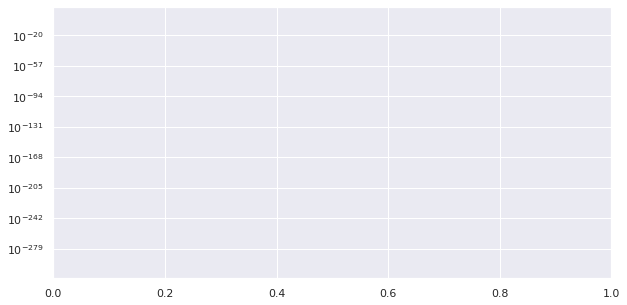

In [155]:
fig,ax = plt.subplots(1,figsize=(10,5))
ax.set_yscale('log')
plot_grid_search(df,ax,
                 plot_SGD=True,
                 plot_Adam=True,
                 plot_AdamW=True,
                 plot_runs=True,
                 plot_fit=True,
                 fit_type="linear",
                 plot_mean=True,
                 train=True)
ax.set_title("Whatever you wanna say bout your grid search")


In [120]:
adam_df = df[df.optimizer == 'Adam']
adamW_df = df[df.optimizer == 'AdamW']
sgd_df = df[df.optimizer == 'SGD']
train = False
adam_concat_losses = get_concat_losses(adam_df,train)
adamW_concat_losses = get_concat_losses(adamW_df,train)
sgd_concat_losses = get_concat_losses(sgd_df,train)

x_adam, y_adam= get_inputs_linreg(adam_concat_losses)
x_adamw, y_adamw = get_inputs_linreg(adamw_concat_losses)
student_test(x_adam,y_adam,x_adamw,y_adamw)

0.0

## Statistics test

In [103]:
def student_test(x1,y1,x2,y2,verbose=False):
    y1 = y1.flatten()
    y2 = y2.flatten()
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    l1 = LinearRegression().fit(x1,y1)
    l2 = LinearRegression().fit(x2,y2)
    
    # coeffs for the linear regressions
    b1 = l1.coef_[0]
    b2 = l2.coef_[0]

    pred1 = l1.predict(x1)
    pred2 = l2.predict(x2)

    def steyx(x,y):
        """ get the standard deviation for the regression"""
        x = x.flatten()
        n = x.shape[0]
        a = 1/(n-2)
        b = np.std(y)**2*n
        c = (np.cov(x,y)[0,1]*(n-1))**2
        d = np.std(x)**2*n
        return np.sqrt(a*(b-c/d))
    
    stey1 = steyx(x1,y1)
    stey2 = steyx(x2,y2)

    def gets(x,ste):
        """ get the standard deviation for the slopes"""
        n = x.shape[0]
        return ste/np.sqrt(np.std(x)**2*(n))

    s1 = gets(x1,stey1)
    s2 = gets(x2,stey2)

    diff = np.abs(b2 - b1)
    
    # pythagore relation
    sediff = np.sqrt(s1**2+s2**2)

    df = n1 + n2 - 4

    # t statistic
    t = diff/sediff

    # 2-tailed test
    p = 2*(1 - stats.t.cdf(t,df=df))
    if verbose:
        print(f"b1:{b1}")
        print(f"b2:{b2}")
        print("stey1:",stey1)
        print("stey2:",stey2)
        print("b1-b2:",diff)
        print("sediff:",sediff)
        print("t:",t)
        
    return p

In [8]:
x1 = np.log(np.arange(fake_losses.shape[0])+1)
x2  = np.log(np.arange(fake_losses.shape[0])+1)

X1 = np.repeat(x1,fake_losses.shape[1])
X2 = np.repeat(x2,fake_losses2.shape[1])
X1 = np.expand_dims(X1,axis=1)
X2 = np.expand_dims(X2,axis=1)

y1 = np.reshape(np.log(fake_losses),(fake_losses.shape[0]*fake_losses.shape[1],1))
y2 = np.reshape(np.log(fake_losses2),(fake_losses2.shape[0]*fake_losses2.shape[1],1))

In [9]:
student_test(X1,y1,X2,y2)

3.0207592986997156e-06

b1:10.446509613051834
b2:0.7493587784122165
stey1: 0.534449511533488
stey2: 2.0552198929338066
b1-b2: 9.697150834639617
sediff: 1.5015933352091757
t: 6.457907482180439


0.02314883721661687

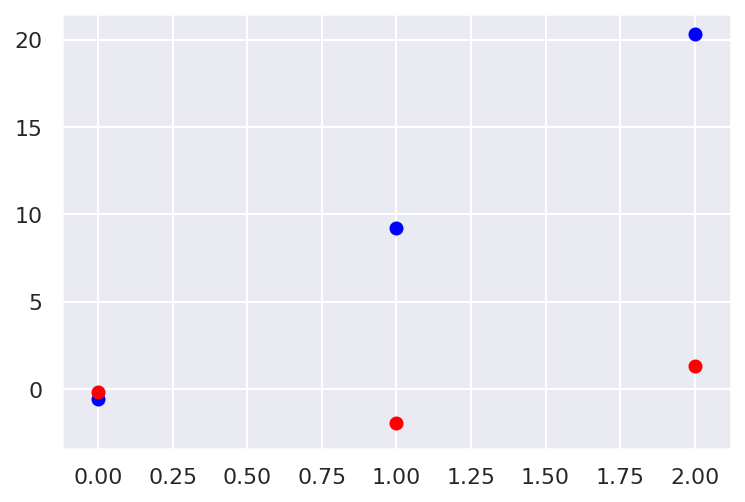

In [97]:
# test example for the student 
X1 = np.arange(3) 
X1 = np.expand_dims(X1,axis=1)
y1 = (10* X1 + np.random.normal(0,1,X1.shape)).flatten() 
y2 = (0.1*X1 + np.random.normal(0,1,X1.shape)).flatten()

plt.scatter(X1,y1,color='blue')
plt.scatter(X1,y2,color='red')
student_test(X1,y1,X1,y2,True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


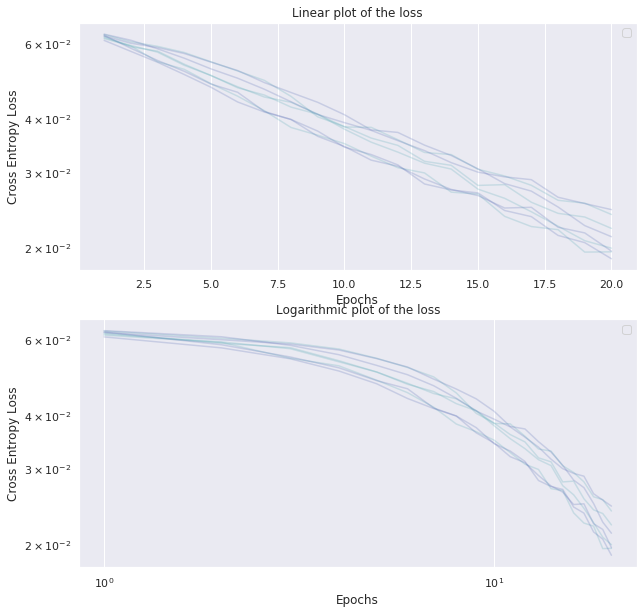

In [10]:
# which run we take
# TODO: if we compute equal gridsearch, we can increase index at sth >0
index = 0
adam = df[df.optimizer == 'Adam'].iloc[index]

param = adam.param
adamw = df[(df.optimizer == 'AdamW') & (df.param == param)].iloc[0]

fig, axes = plt.subplots(2, figsize=(10, 10))
col1 = ("#3e9eab", "#db2e59")
reg1 = plot_losses_fits(adam.train_losses, axes, col1,title="Adam")
col2 = ("#3e57ab", "#ed7002")
reg2 = plot_losses_fits(adamw.train_losses, axes, col2,title="AdamW")

x_adam, y_adam = get_inputs_linreg(adam.train_losses)
x_adamw, y_adamw = get_inputs_linreg(adamw.train_losses)
#student_test(x_adam,y_adam,x_adamw,y_adamw)

In [30]:
def plot_df(df,color,label,train=True):
        """
        plot the train
        """
        for i,(_,row) in enumerate(df.iterrows()):
            losses = row.train_losses if train else row.validation_losses
            for j,loss in enumerate(losses):
                if (not isinstance(loss,float)):
                    ax.plot(np.arange(len(loss))+1,loss,color=color,alpha=0.2,label=label if j== 0 and i==0 else None )

def plot_grid_search(df,ax,plot_SGD=True,plot_Adam=True,plot_AdamW=True,y_scale="log"):
    """
    
    """
    # color fofig, ax = plt.subplots(1, figsize=(10, 8))
    
    adam_df = df[df.optimizer == 'Adam']
    adamw_df = df[df.optimizer == 'AdamW']
    sgd_df = df[df.optimizer == 'SGD']
    if plot_SGD:
        plot_df(sgd_df,color=colSGD,label='SGD')
    if plot_Adam:
        plot_df(adam_df,color=coladam,label='Adam')
    if plot_AdamW:
        plot_df(adamw_df,color=coladamw,label='AdamW')

    ax.set_yscale(y_scale)
    ax.legend()
    ax.set_title("Confounded Grid Search runs for Adam and AdamW")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Training Loss (Cross Entropy)')